In [ ]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

import torch
import numpy as np
import random
from time import time
from copy import deepcopy
from torch import nn
import os
from torchsummary import summary
from torch.autograd import Variable
from torch.nn import functional as F 

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid 
import matplotlib.pyplot as plt
import seaborn as sns


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0) 
torch.backends.cudnn.deterministic = True

#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
from torchvision import transforms

MNIST_train = MNIST('./', download=True, transform = transforms.ToTensor(), train=True)
MNIST_test = MNIST('./', download=True, transform = transforms.ToTensor(), train=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
!nvidia-smi

Mon Mar 28 14:56:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_indices_01 = []; train_indices_23 = []; train_indices_45 = []; train_indices_67 = []; train_indices_89 = []
test_indices_01 = []; test_indices_23 = []; test_indices_45 = []; test_indices_67 = []; test_indices_89 = []
for i in range(len(y_train)):
  if y_train[i] == 0 or y_train[i] == 1:
    train_indices_01.append(i)
  elif y_train[i] == 2 or y_train[i] == 3:
    train_indices_23.append(i)
  elif y_train[i] == 4 or y_train[i] == 5:
    train_indices_45.append(i)
  elif y_train[i] == 6 or y_train[i] == 7:
    train_indices_67.append(i)
  elif y_train[i] == 8 or y_train[i] == 9:
    train_indices_89.append(i)
  


for i in range(len(y_test)):
  if y_test[i] == 0 or y_test[i] == 1:
    test_indices_01.append(i)
  elif y_test[i] == 2 or y_test[i]== 3:
    test_indices_23.append(i)
  elif y_test[i] == 4 or y_test[i] == 5:
    test_indices_45.append(i)
  elif y_test[i] == 6 or y_test[i] == 7:
    test_indices_67.append(i)
  elif y_test[i] == 8 or y_test[i] == 9:
    test_indices_89.append(i)



X_train_01 = X_train[train_indices_01]
y_train_01 = y_train[train_indices_01]
X_test_01 = X_test[test_indices_01]
y_test_01 = y_test[test_indices_01]

X_train_23 = X_train[train_indices_23]
y_train_23 = y_train[train_indices_23]
X_test_23 = X_test[test_indices_23]
y_test_23 = y_test[test_indices_23]

X_train_45 = X_train[train_indices_45]
y_train_45 = y_train[train_indices_45]
X_test_45 = X_test[test_indices_45]
y_test_45 = y_test[test_indices_45]

X_train_67 = X_train[train_indices_67]
y_train_67 = y_train[train_indices_67]
X_test_67 = X_test[test_indices_67]
y_test_67 = y_test[test_indices_67]

X_train_89 = X_train[train_indices_89]
y_train_89 = y_train[train_indices_89]
X_test_89 = X_test[test_indices_89]
y_test_89 = y_test[test_indices_89]



In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

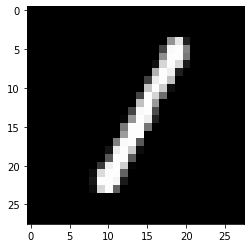

tensor(1)


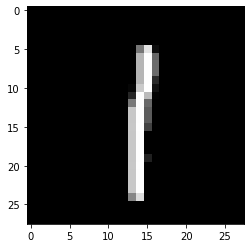

tensor(1)


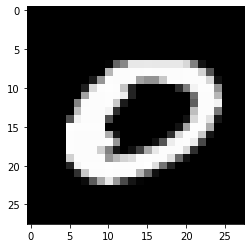

tensor(0)


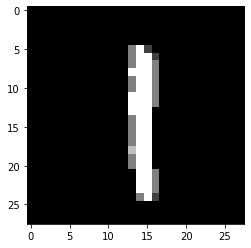

tensor(1)


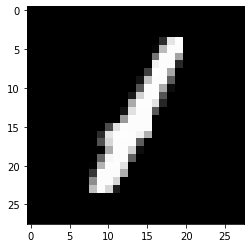

tensor(1)


In [ ]:
def plot_num(x, y, count = 5):
    for i in np.random.permutation(len(x))[:count]:
        plt.imshow(x[i,:,:], cmap = 'gray')
        plt.show()
        print(y[i])
plot_num(X_train_01, y_train_01) 



In [ ]:
X_train = X_train.unsqueeze(1).float()/255
X_test = X_test.unsqueeze(1).float()/255

X_train_01 = X_train_01.unsqueeze(1).float()/255
X_test_01 = X_test_01.unsqueeze(1).float()/255
X_test_01 = X_test_01.to(device)

X_train_23 = X_train_23.unsqueeze(1).float()/255
X_test_23 = X_test_23.unsqueeze(1).float()/255
X_test_23 = X_test_23.to(device)

X_train_45 = X_train_45.unsqueeze(1).float()/255
X_test_45 = X_test_45.unsqueeze(1).float()/255
X_test_45 = X_test_45.to(device)

X_train_67 = X_train_67.unsqueeze(1).float()/255
X_test_67 = X_test_67.unsqueeze(1).float()/255
X_test_67 = X_test_67.to(device)

X_train_89 = X_train_89.unsqueeze(1).float()/255
X_test_89 = X_test_89.unsqueeze(1).float()/255
X_test_89 = X_test_89.to(device)

In [ ]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
image_size = 28
batch_size = 128


In [ ]:
class LeNet(torch.nn.Module):
  def __init__(self,activation = 'leaky relu', pooling = 'max', conv_size = 3, use_batch_norm = False, use_dropout = False):
    super(LeNet, self).__init__()
    self.conv_size = conv_size
    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout

    if activation == 'relu':
      activation_function = torch.nn.ReLU()
    elif activation == 'tanh':
      activation_function = torch.nn.Tanh()
    elif activation == 'leaky relu':
        activation_function = torch.nn.LeakyReLU()
    else:
      raise NotImplementedError   

    if pooling == 'max':
      pooling_layer = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
    elif pooling == 'avg':
      pooling_layer = torch.nn.AvgPool2d(kernel_size = 2, stride = 2)
    else:
      raise NotImplementedError   
    
    if conv_size == 3:
      self.conv1_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
      self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
    elif conv_size == 5:
      self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
    else:
      raise NotImplementedError
    
    self.act1 = activation_function
    self.bn1 = torch.nn.BatchNorm2d(num_features=6)
    self.pool1 = pooling_layer
    self.dp1 = torch.nn.Dropout(p = 0.25) 

    if conv_size == 3:
      self.conv2_1 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
      self.conv2_2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0)
    elif conv_size == 5:
      self.conv2 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=0)
    else:
      raise NotImplementedError

    self.act2 = activation_function
    self.bn2 = torch.nn.BatchNorm2d(num_features=16)
    self.pool2 = pooling_layer
    self.dp2 = torch.nn.Dropout(p=0.25) 

    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.act3 = torch.nn.Tanh()
    self.dp3 = torch.nn.Dropout(p = 0.5) 

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = torch.nn.Tanh()
    self.dp4 = torch.nn.Dropout(p=0.5) 

    self.fc3 = torch.nn.Linear(84,10)
    self.act5 = torch.nn.Softmax()


  def forward(self,x):
    if self.conv_size == 3:
      x = self.conv1_1(x)
      x = self.conv1_2(x)
    elif self.conv_size == 5:
      x = self.conv1(x)

    x = self.act1(x)
    if self.use_batch_norm:
      x = self.bn1(x)
    x = self.pool1(x)
    if self.use_dropout:
      x = self.dp1(x)


    if self.conv_size == 3:
      x = self.conv2_1(x)
      x = self.conv2_2(x)
    elif self.conv_size == 5:
      x = self.conv2(x)
    
    x = self.act2(x)
    if self.use_batch_norm:
      x = self.bn2(x)
    x = self.pool2(x)
    if self.use_dropout:
      x = self.dp2(x)

    x = x.view(x.size(0),x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    if self.use_dropout:
      x = self.dp3(x)
    x = self.fc2(x)
    x = self.act4(x)
    if self.use_dropout:
      x = self.dp4(x)
    x = self.fc3(x)
    x = self.act5(x)
    
    x = x.to(device)

    return x

lenet = LeNet(use_batch_norm = True, use_dropout =True)
lenet = lenet.to(device)
loss = torch.nn.CrossEntropyLoss()
my_optimizer = torch.optim.Adam(lenet.parameters(), lr=4.0e-4)



def variable(t: torch.Tensor, use_cuda=True, **kwargs): 
    if torch.cuda.is_available() and use_cuda:         
        t = t.cuda()
    return Variable(t, **kwargs)


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break    

class EWC(object):
    def __init__(self, old_x, old_y = None, model = lenet):

        self.model = model
        self.old_x = old_x
        self.old_y = old_y
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._old_params = {}
        self._precision_matrices = self._diag_fisher() 

        for n, p in deepcopy(self.params).items():
            self._old_params[n] = variable(p.data)


    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items(): 
            p.data.zero_() 
            precision_matrices[n] = variable(p.data) 

        self.model.eval() 
        self.model.zero_grad() 
        self.old_x = variable(self.old_x) 
        output = self.model(self.old_x)
        output = output.to(device)
        loss = F.nll_loss(F.log_softmax(output, dim=1), self.old_y)
        #loss = F.nll_loss(output, self.old_y)

        loss.backward()

        for n, p in self.model.named_parameters():
            precision_matrices[n].data += p.grad.data ** 2 / len(self.old_x)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n].data * (p - self._old_params[n].data) ** 2
            loss += _loss.sum()
        return loss


def test_accuracy(x_test, y_test):
    x_test = x_test.to(device)
    test_preds = lenet.forward(x_test)
    test_preds = test_preds.to(device)
    y_test = y_test.to(device)
    accuracy = (test_preds.argmax(dim = 1) == y_test).float().mean().data.cpu()
    return accuracy



def normal_train(X_trains, y_trains, X_tests, y_tests, number, model = lenet, optimizer = my_optimizer, epochs = 10, batch_sizes = 64):
    model.train()
    torch.cuda.empty_cache()
    batch_size = batch_sizes
    test_accuracy_history = []
    best_accuracy = 0
    test_loss_history = []

    X_tests = X_tests.to(device)
    y_tests = y_tests.to(device)

    for epoch in range(epochs):
        order = np.random.permutation(len(X_trains))
        for start_index in range(0,len(X_trains), batch_size):
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_trains[batch_indexes].to(device)
            y_batch = y_trains[batch_indexes].to(device)

            X_batch, y_batch = variable(X_batch), variable(y_batch)
            optimizer.zero_grad()
            preds = model.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_preds = model.forward(X_tests)
            test_loss_history.append(loss(test_preds, y_tests).data.cpu())

        accuracy = (test_preds.argmax(dim = 1) == y_tests).float().mean().data.cpu()
        if number == 1:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
        elif number == 2:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23),)
        elif number == 3:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
        elif number == 4:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
            print('accuracy on 67: ', test_accuracy(X_test_67,y_test_67))
        elif number == 5:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
            print('accuracy on 67: ', test_accuracy(X_test_67,y_test_67))    
            print('accuracy on 89: ', test_accuracy(X_test_89,y_test_89))    

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = model.state_dict()
        test_accuracy_history.append(accuracy)
        print('total accuracy:',accuracy, '\n')
    model.load_state_dict(best_weights)
    return test_accuracy_history, test_loss_history



def ewc_train(X_trains, y_trains, X_tests, y_tests, old_x_test, old_y_test, number, 
              ewc: EWC, importance, epochs = 0, model = lenet, optimizer = my_optimizer, batch_sizes = 64):
    model.train()
    batch_size = batch_sizes
    test_accuracy_history = []
    test_loss_history = []
    best_accuracy = 0

    X_tests = X_tests.to(device)
    y_tests = y_tests.to(device)
    temp_epoch = 1
    while True:
        order = np.random.permutation(len(X_trains))
        for start_index in range(0,len(X_trains), batch_size):
            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_trains[batch_indexes].to(device)
            y_batch = y_trains[batch_indexes].to(device)

            X_batch, y_batch = variable(X_batch), variable(y_batch)
            optimizer.zero_grad()
            preds = model.forward(X_batch)
            loss_value = loss(preds, y_batch) + importance * ewc.penalty(model)
            loss_value.backward()
            optimizer.step()
        
        test_preds = model.forward(X_tests)
        test_loss_history.append(loss(test_preds, y_tests).data.cpu())

        accuracy = (test_preds.argmax(dim = 1) == y_tests).float().mean().data.cpu()
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_weights = model.state_dict()
        test_accuracy_history.append(accuracy)
        old_accuracy = test_accuracy(old_x_test, old_y_test)
        print('accuracy on current task: ',accuracy)
        print('accuracy on old task: ', old_accuracy)
        if number == 1:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
        elif number == 2:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
        elif number == 3:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
        elif number == 4:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
            print('accuracy on 67: ', test_accuracy(X_test_67,y_test_67))

        elif number == 5:
            print('accuracy on 01: ', test_accuracy(X_test_01,y_test_01))
            print('accuracy on 23: ', test_accuracy(X_test_23,y_test_23))
            print('accuracy on 45: ', test_accuracy(X_test_45,y_test_45))
            print('accuracy on 67: ', test_accuracy(X_test_67,y_test_67))    
            print('accuracy on 89: ', test_accuracy(X_test_89,y_test_89)) 

        temp_epoch += 1
        if (accuracy >= old_accuracy or (abs(accuracy - old_accuracy) <= 0.05 and number == 1) or abs(accuracy - old_accuracy) <= 0.03) and temp_epoch >= epochs:
            break
    model.load_state_dict(best_weights)
    return test_accuracy_history, test_loss_history


In [ ]:
discriminator = nn.Sequential(
    # in: 1 x 28 x 28

    nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 16 x 14 x 14

    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 7 x 7

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 5 x 5

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 3 x 3

    nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 32 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 128, kernel_size=3, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 3 x 3

    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 5 x 5

    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 7 x 7

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(True),
    # out: 16 x 14 x 14

    nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 28 x 28
)

In [ ]:
summary(lenet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
            Conv2d-2            [-1, 6, 28, 28]             330
         LeakyReLU-3            [-1, 6, 28, 28]               0
       BatchNorm2d-4            [-1, 6, 28, 28]              12
         MaxPool2d-5            [-1, 6, 14, 14]               0
           Dropout-6            [-1, 6, 14, 14]               0
            Conv2d-7           [-1, 16, 12, 12]             880
            Conv2d-8           [-1, 16, 10, 10]           2,320
         LeakyReLU-9           [-1, 16, 10, 10]               0
      BatchNorm2d-10           [-1, 16, 10, 10]              32
        MaxPool2d-11             [-1, 16, 5, 5]               0
          Dropout-12             [-1, 16, 5, 5]               0
           Linear-13                  [-1, 120]          48,120
             Tanh-14                  [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
summary(discriminator.to(device), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             256
       BatchNorm2d-2           [-1, 16, 14, 14]              32
         LeakyReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           8,192
       BatchNorm2d-5             [-1, 32, 7, 7]              64
         LeakyReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 5, 5]          18,432
       BatchNorm2d-8             [-1, 64, 5, 5]             128
         LeakyReLU-9             [-1, 64, 5, 5]               0
           Conv2d-10            [-1, 128, 3, 3]          73,728
      BatchNorm2d-11            [-1, 128, 3, 3]             256
        LeakyReLU-12            [-1, 128, 3, 3]               0
           Conv2d-13              [-1, 1, 1, 1]           1,152
          Flatten-14                   

In [ ]:
summary(generator.to(device), (latent_size, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 128, 3, 3]          36,864
       BatchNorm2d-2            [-1, 128, 3, 3]             256
              ReLU-3            [-1, 128, 3, 3]               0
   ConvTranspose2d-4             [-1, 64, 5, 5]          73,728
       BatchNorm2d-5             [-1, 64, 5, 5]             128
              ReLU-6             [-1, 64, 5, 5]               0
   ConvTranspose2d-7             [-1, 32, 7, 7]          18,432
       BatchNorm2d-8             [-1, 32, 7, 7]              64
              ReLU-9             [-1, 32, 7, 7]               0
  ConvTranspose2d-10           [-1, 16, 14, 14]           8,192
      BatchNorm2d-11           [-1, 16, 14, 14]              32
             ReLU-12           [-1, 16, 14, 14]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]             256
             Tanh-14            [-1, 1,

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

def show_samples(index, latent_tensors):
    with torch.no_grad():
        fake_images = generator(latent_tensors)
    fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
    for j in range(5):
        ax[0][j].imshow(fake_images[j].detach().squeeze().cpu(), cmap ='gray')
    for j in range(5):
        ax[1][j].imshow(fake_images[j+5].detach().squeeze().cpu(),cmap='gray')

In [ ]:
lr = 4e-4
model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.MSELoss(),
}

In [ ]:
train_dl = DataLoader(X_train_01, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def fit_GAN(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5,0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(train_dl):
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images.to(device))
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_noise = np.random.uniform(low=0.0,high=0.3, size=real_targets.shape)
            # добавим шум к реальным отметкам
            real_targets -= torch.Tensor(real_noise).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # генерируем изображение
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            # Подаем фейки в дискриминатор, говоря что это фейки
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_noise = np.random.uniform(low=0.0, high=0.3, size=fake_targets.shape)
            fake_targets += torch.Tensor(fake_noise).to(device)
            #но с шумом
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Обновляем веса дискриминатора
            loss_d = real_loss + fake_loss
            loss_d.backward(inputs=list(model['discriminator'].parameters()))
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Обучение генератора
            optimizer["generator"].zero_grad()
            
            # Опять генерим фейки
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Но говорим дискриминатору, что они реальные
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Берем градиент по генератору
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Записываем лоссы
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        if epoch % 5 == 0:
            show_samples(epoch, fixed_latent)
        
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model['discriminator'] = model['discriminator'].to(device)
model['generator'] = model['generator'].to(device)
lenet = lenet.to(device)

In [ ]:
%%time
test_acc, test_loss = normal_train(X_train_01,y_train_01,X_test_01,y_test_01, number=1) #обучаем классификатор на 01

accuracy on 01:  tensor(0.9991)
total accuracy: tensor(0.9991) 

accuracy on 01:  tensor(1.)
total accuracy: tensor(1.) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9995) 

accuracy on 01:  tensor(0.9991)
total accuracy: tensor(0.9991) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9995) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9995) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9995) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9995) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9995) 

accuracy on 01:  tensor(0.9995)
total accuracy: tensor(0.9995) 

CPU times: user 15.8 s, sys: 363 ms, total: 16.1 s
Wall time: 16.1 s


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 0.7777, loss_d: 0.9537, real_score: 0.7769, fake_score: 0.2596


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 0.7955, loss_d: 0.8893, real_score: 0.8262, fake_score: 0.1737


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 0.7830, loss_d: 0.8961, real_score: 0.8170, fake_score: 0.1831


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 0.7537, loss_d: 0.9283, real_score: 0.7902, fake_score: 0.2096


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 0.7517, loss_d: 0.8982, real_score: 0.8100, fake_score: 0.1936


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 0.7354, loss_d: 0.9173, real_score: 0.8012, fake_score: 0.1984


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 0.7298, loss_d: 0.9060, real_score: 0.8082, fake_score: 0.1887


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 0.7280, loss_d: 0.8998, real_score: 0.8101, fake_score: 0.1892


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 0.7114, loss_d: 0.9247, real_score: 0.7942, fake_score: 0.2043


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 0.6962, loss_d: 0.9068, real_score: 0.8081, fake_score: 0.1915


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 0.7044, loss_d: 0.9150, real_score: 0.8015, fake_score: 0.1968


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 0.7136, loss_d: 0.9189, real_score: 0.8046, fake_score: 0.1948


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 0.6951, loss_d: 0.9135, real_score: 0.7994, fake_score: 0.2012


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 0.7101, loss_d: 0.9073, real_score: 0.8059, fake_score: 0.1927


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 0.6979, loss_d: 0.9259, real_score: 0.7959, fake_score: 0.2047


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 0.6938, loss_d: 0.9172, real_score: 0.7990, fake_score: 0.2015


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 0.6928, loss_d: 0.9079, real_score: 0.8050, fake_score: 0.1974


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 0.6952, loss_d: 0.9163, real_score: 0.7978, fake_score: 0.2001


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 0.6975, loss_d: 0.9031, real_score: 0.8070, fake_score: 0.1930


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 0.6874, loss_d: 0.9243, real_score: 0.7971, fake_score: 0.2052


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 0.6870, loss_d: 0.9122, real_score: 0.7990, fake_score: 0.2003


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 0.6784, loss_d: 0.9403, real_score: 0.7861, fake_score: 0.2127


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 0.6670, loss_d: 0.9207, real_score: 0.7941, fake_score: 0.2050


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 0.6584, loss_d: 0.9410, real_score: 0.7862, fake_score: 0.2145


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 0.6745, loss_d: 0.9025, real_score: 0.8033, fake_score: 0.1984


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 0.6763, loss_d: 0.9174, real_score: 0.7981, fake_score: 0.2032


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 0.6747, loss_d: 0.9248, real_score: 0.7935, fake_score: 0.2052


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 0.6817, loss_d: 0.9202, real_score: 0.7966, fake_score: 0.2039


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 0.6937, loss_d: 0.8966, real_score: 0.8080, fake_score: 0.1898


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 0.6756, loss_d: 0.9404, real_score: 0.7898, fake_score: 0.2098


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 0.6522, loss_d: 0.9465, real_score: 0.7798, fake_score: 0.2188


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 0.6731, loss_d: 0.9123, real_score: 0.7991, fake_score: 0.1998


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 0.6799, loss_d: 0.9181, real_score: 0.8011, fake_score: 0.1992


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 0.6915, loss_d: 0.9107, real_score: 0.8044, fake_score: 0.1981


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 0.6849, loss_d: 0.9176, real_score: 0.8055, fake_score: 0.1924


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 0.6636, loss_d: 0.9312, real_score: 0.7904, fake_score: 0.2103


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 0.6760, loss_d: 0.9281, real_score: 0.7925, fake_score: 0.2063


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 0.6742, loss_d: 0.9186, real_score: 0.7955, fake_score: 0.2031


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 0.6688, loss_d: 0.9283, real_score: 0.7893, fake_score: 0.2103


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 0.6769, loss_d: 0.9129, real_score: 0.7999, fake_score: 0.1998


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 0.6815, loss_d: 0.9168, real_score: 0.7982, fake_score: 0.2021


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 0.6483, loss_d: 0.9446, real_score: 0.7829, fake_score: 0.2185


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 0.6777, loss_d: 0.9380, real_score: 0.7901, fake_score: 0.2066


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 0.6717, loss_d: 0.9294, real_score: 0.7883, fake_score: 0.2114


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 0.6873, loss_d: 0.9120, real_score: 0.8041, fake_score: 0.1942


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 0.6849, loss_d: 0.9271, real_score: 0.7969, fake_score: 0.2023


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 0.6767, loss_d: 0.9189, real_score: 0.7937, fake_score: 0.2060


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 0.6579, loss_d: 0.9294, real_score: 0.7914, fake_score: 0.2082


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 0.6717, loss_d: 0.9098, real_score: 0.8007, fake_score: 0.1989


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 0.6708, loss_d: 0.9533, real_score: 0.7881, fake_score: 0.2107


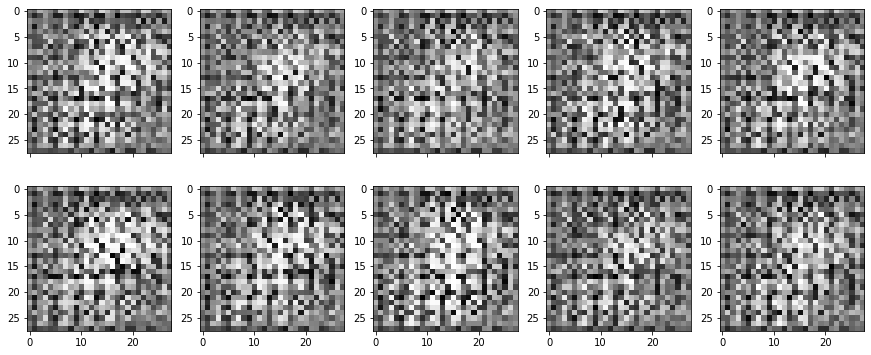

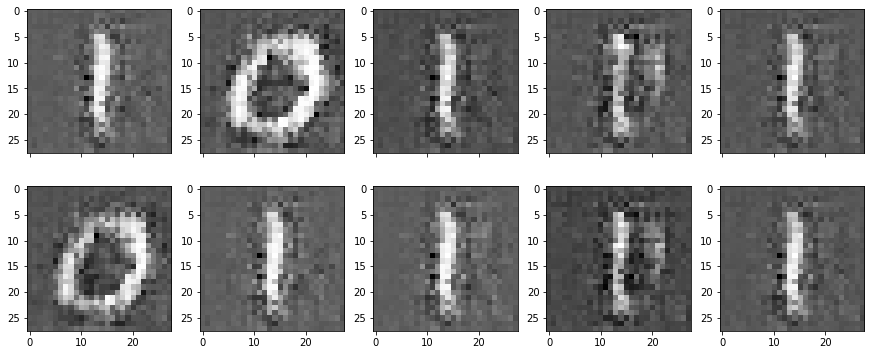

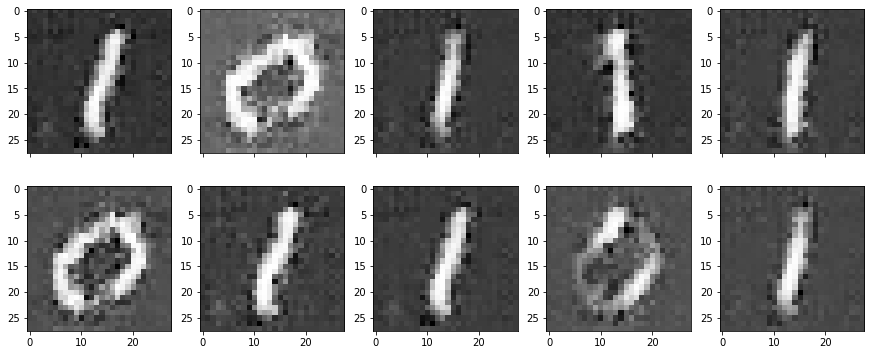

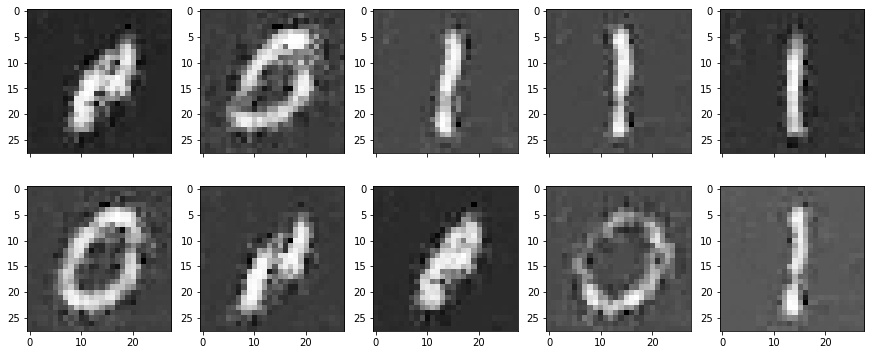

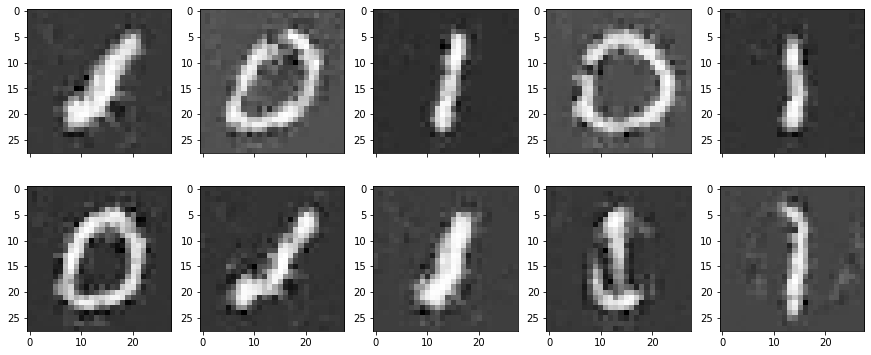

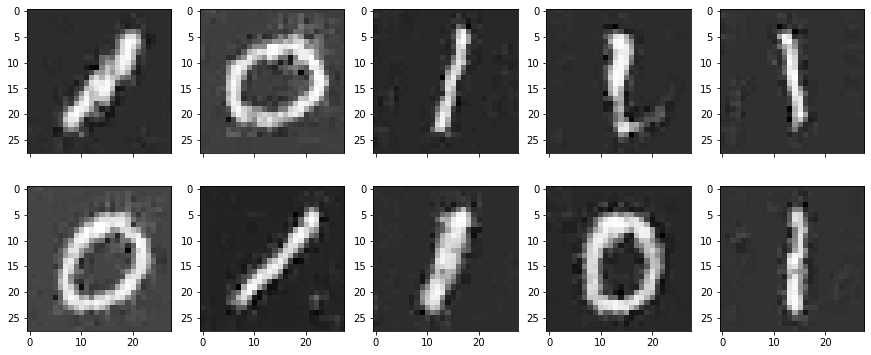

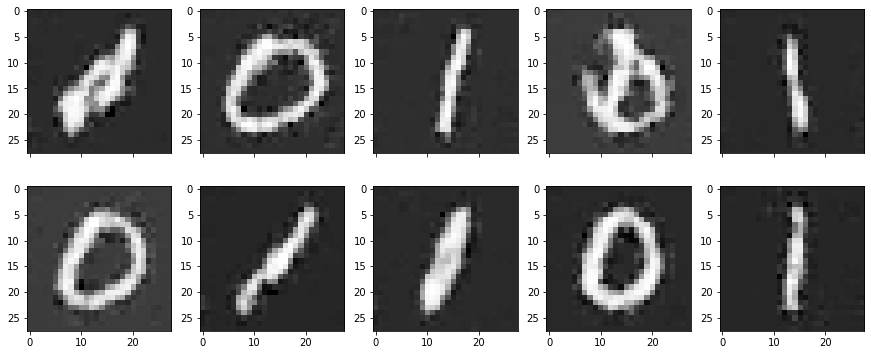

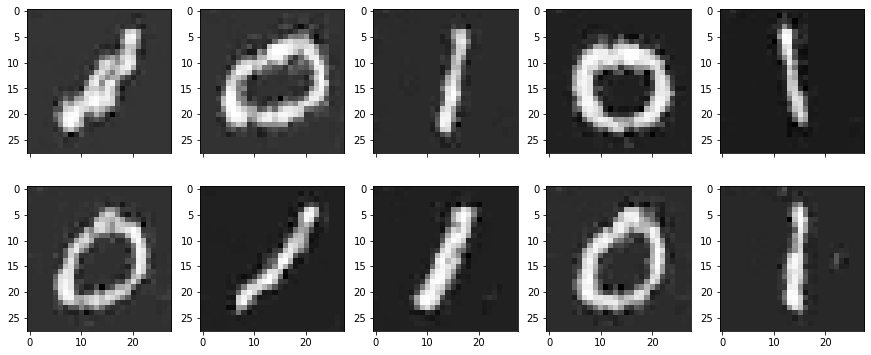

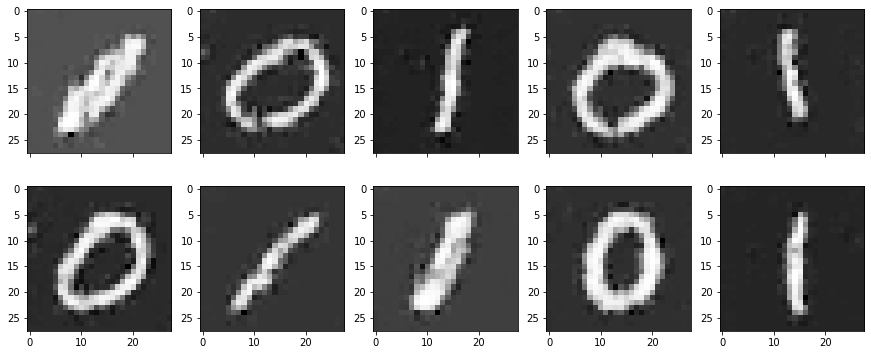

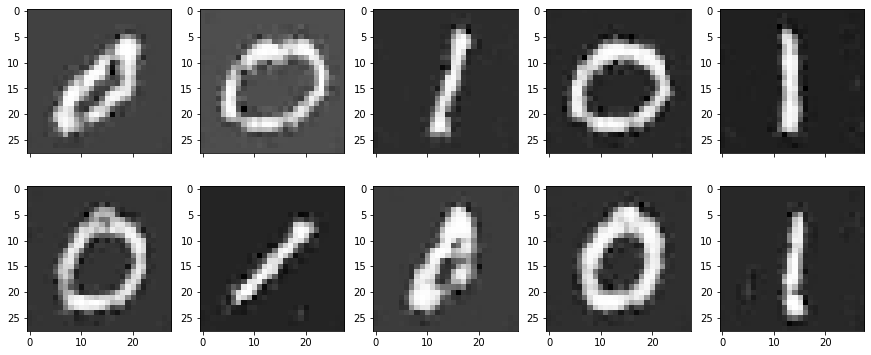

In [ ]:
%%time
lg, ld, rs, fs = fit_GAN(model, criterion, 50, lr=lr)

sum of 0 in generated samples: tensor(5887, device='cuda:0')
sum of 1 in generated samples: tensor(6778, device='cuda:0')


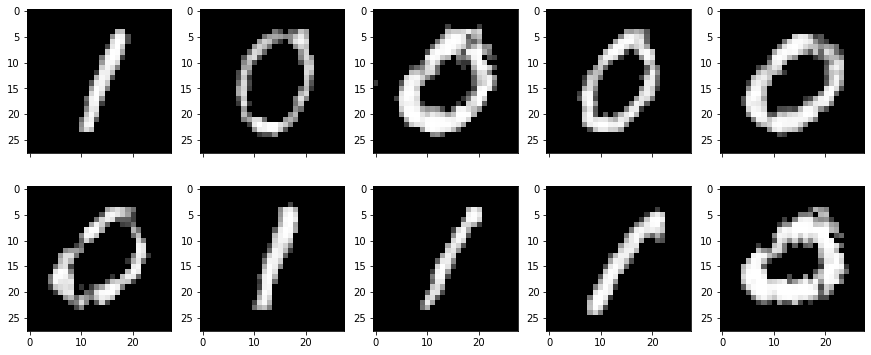

In [ ]:
generator.eval()
discriminator.eval()
lenet.eval()
train_latent = torch.randn(len(X_train_01), latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model['generator'](train_latent)
fake_images[fake_images <= 2e-1] = 0
fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(fake_images[j].detach().squeeze().cpu(), cmap ='gray')
for j in range(5):
    ax[1][j].imshow(fake_images[j+5].detach().squeeze().cpu(),cmap='gray')

prev_X = torch.clone(fake_images)
with torch.no_grad():
    prev_y = lenet(prev_X).argmax(axis=1)

for i in range(max(prev_y)+1):
    print(f'sum of {i} in generated samples:', sum(prev_y == i))

torch.cuda.empty_cache()

In [ ]:
new_X_train = torch.cat((prev_X, X_train_23.to(device)))
new_y_train = torch.cat((prev_y, y_train_23.to(device)))
permutation = np.random.permutation(len(new_X_train))
new_X_train = new_X_train[permutation]
new_y_train = new_y_train[permutation]
prev_X_test = X_test_01
prev_y_test = y_test_01.to(device)
cur_X_test = torch.cat((prev_X_test, X_test_23))
cur_y_test = torch.cat((prev_y_test, y_test_23.to(device)))
my_ewc = EWC(prev_X, prev_y)


In [ ]:
%%time   
test_acc, test_loss = ewc_train(new_X_train, new_y_train, cur_X_test, cur_y_test, prev_X_test, 
          prev_y_test, number=2, ewc=my_ewc, importance=3.3e14, epochs=10) #обучаем классификатор на 0123  

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs
accuracy on current task:  tensor(0.9083)
accuracy on old task:  tensor(0.9508)
accuracy on 01:  tensor(0.9470)
accuracy on 23:  tensor(0.8683)
accuracy on current task:  tensor(0.9168)
accuracy on old task:  tensor(0.9333)
accuracy on 01:  tensor(0.9215)
accuracy on 23:  tensor(0.8766)
accuracy on current task:  tensor(0.9216)
accuracy on old task:  tensor(0.9423)
accuracy on 01:  tensor(0.9466)
accuracy on 23:  tensor(0.8903)
accuracy on current task:  tensor(0.9175)
accuracy on old task:  tensor(0.8993)
accuracy on 01:  tensor(0.8969)
accuracy on 23:  tensor(0.8962)
accuracy on current task:  tensor(0.9175)
accuracy on old task:  tensor(0.9182)
accuracy on 01:  tensor(0.9121)
accuracy on 23:  tensor(0.9128)
accuracy on current task:  tensor(0.9242)
accuracy on old task:  tensor(0.8993)
accuracy on 01:  tensor(0.9050)
accuracy on 23:  tensor(0.9089)
accuracy on current task:  tensor(0.9278)
accuracy on old task:  ten

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 0.6738, loss_d: 0.9477, real_score: 0.7789, fake_score: 0.2202


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 0.6818, loss_d: 0.9133, real_score: 0.7985, fake_score: 0.2007


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 0.6804, loss_d: 0.9167, real_score: 0.7996, fake_score: 0.1988


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 0.6692, loss_d: 0.9230, real_score: 0.7913, fake_score: 0.2071


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 0.6650, loss_d: 0.9393, real_score: 0.7858, fake_score: 0.2143


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 0.6668, loss_d: 0.9267, real_score: 0.7896, fake_score: 0.2094


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 0.6673, loss_d: 0.9290, real_score: 0.7885, fake_score: 0.2106


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 0.6679, loss_d: 0.9284, real_score: 0.7892, fake_score: 0.2107


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 0.6718, loss_d: 0.9303, real_score: 0.7887, fake_score: 0.2101


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 0.6492, loss_d: 0.9492, real_score: 0.7739, fake_score: 0.2253


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 0.6502, loss_d: 0.9467, real_score: 0.7722, fake_score: 0.2265


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 0.6511, loss_d: 0.9470, real_score: 0.7750, fake_score: 0.2223


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 0.6450, loss_d: 0.9504, real_score: 0.7698, fake_score: 0.2297


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 0.6386, loss_d: 0.9489, real_score: 0.7717, fake_score: 0.2271


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 0.6303, loss_d: 0.9610, real_score: 0.7666, fake_score: 0.2339


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 0.6059, loss_d: 1.0029, real_score: 0.7428, fake_score: 0.2557


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 0.5994, loss_d: 0.9697, real_score: 0.7487, fake_score: 0.2499


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 0.5909, loss_d: 0.9955, real_score: 0.7385, fake_score: 0.2623


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 0.5748, loss_d: 0.9975, real_score: 0.7338, fake_score: 0.2650


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 0.5790, loss_d: 1.0014, real_score: 0.7301, fake_score: 0.2686


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 0.5913, loss_d: 0.9906, real_score: 0.7378, fake_score: 0.2633


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 0.5794, loss_d: 0.9996, real_score: 0.7331, fake_score: 0.2662


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 0.5732, loss_d: 1.0092, real_score: 0.7264, fake_score: 0.2734


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 0.5682, loss_d: 1.0142, real_score: 0.7244, fake_score: 0.2770


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 0.5758, loss_d: 1.0151, real_score: 0.7228, fake_score: 0.2775


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 0.5602, loss_d: 1.0162, real_score: 0.7241, fake_score: 0.2752


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 0.5623, loss_d: 1.0079, real_score: 0.7255, fake_score: 0.2738


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 0.5660, loss_d: 1.0091, real_score: 0.7259, fake_score: 0.2755


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 0.5609, loss_d: 1.0204, real_score: 0.7232, fake_score: 0.2779


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 0.5631, loss_d: 1.0125, real_score: 0.7237, fake_score: 0.2742


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 0.5633, loss_d: 1.0171, real_score: 0.7211, fake_score: 0.2789


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 0.5529, loss_d: 1.0256, real_score: 0.7191, fake_score: 0.2808


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 0.5619, loss_d: 1.0012, real_score: 0.7292, fake_score: 0.2709


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 0.5637, loss_d: 1.0088, real_score: 0.7288, fake_score: 0.2726


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 0.5542, loss_d: 1.0225, real_score: 0.7247, fake_score: 0.2774


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 0.5683, loss_d: 1.0092, real_score: 0.7260, fake_score: 0.2718


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 0.5708, loss_d: 1.0111, real_score: 0.7279, fake_score: 0.2735


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 0.5655, loss_d: 1.0024, real_score: 0.7301, fake_score: 0.2686


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 0.5582, loss_d: 1.0174, real_score: 0.7269, fake_score: 0.2738


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 0.5756, loss_d: 1.0115, real_score: 0.7273, fake_score: 0.2727


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 0.5618, loss_d: 1.0132, real_score: 0.7282, fake_score: 0.2720


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 0.5728, loss_d: 0.9906, real_score: 0.7381, fake_score: 0.2611


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 0.5688, loss_d: 1.0217, real_score: 0.7275, fake_score: 0.2714


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 0.5811, loss_d: 0.9997, real_score: 0.7350, fake_score: 0.2670


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 0.5792, loss_d: 1.0038, real_score: 0.7337, fake_score: 0.2624


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 0.5850, loss_d: 0.9966, real_score: 0.7372, fake_score: 0.2613


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 0.5799, loss_d: 0.9876, real_score: 0.7431, fake_score: 0.2591


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 0.5782, loss_d: 1.0173, real_score: 0.7289, fake_score: 0.2684


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 0.5818, loss_d: 0.9925, real_score: 0.7400, fake_score: 0.2609


  0%|          | 0/194 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 0.5896, loss_d: 0.9999, real_score: 0.7394, fake_score: 0.2623


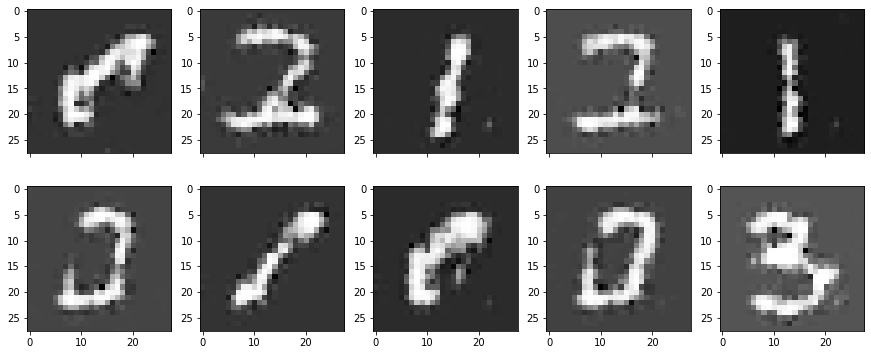

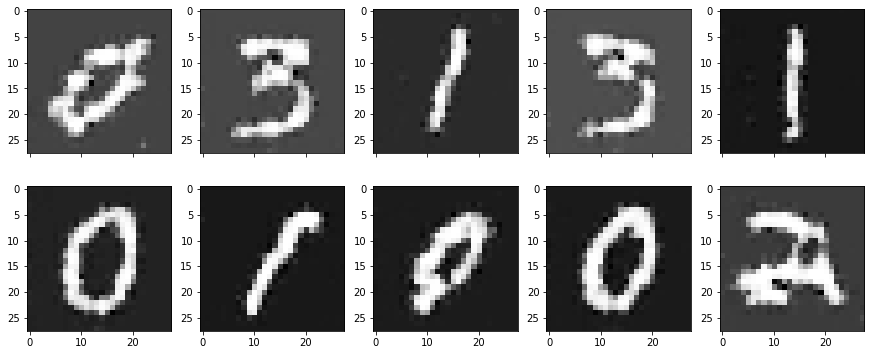

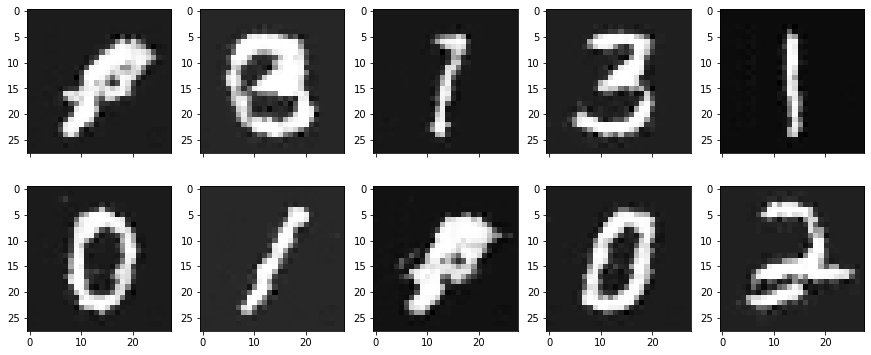

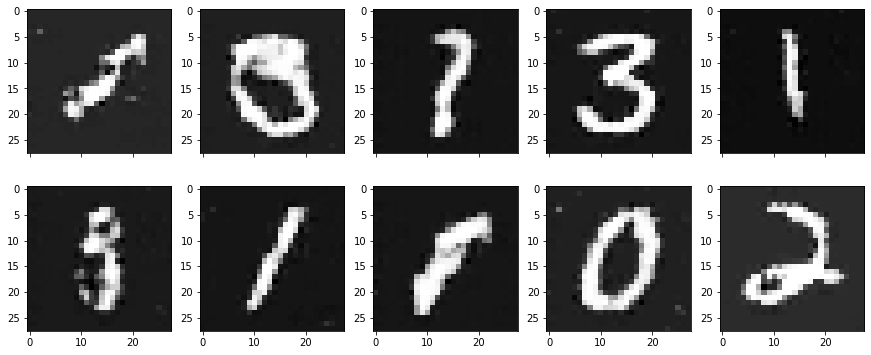

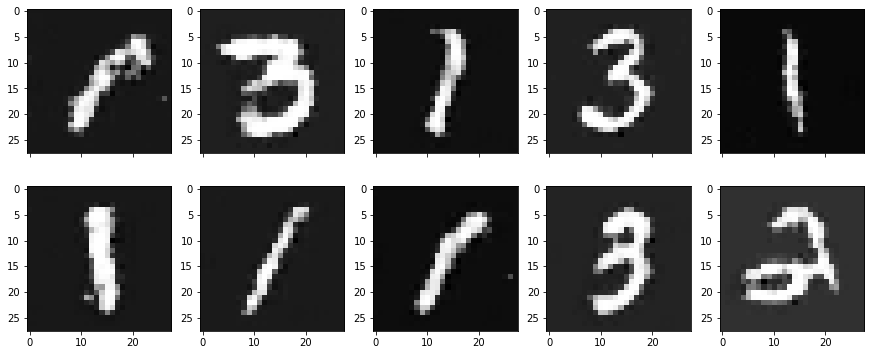

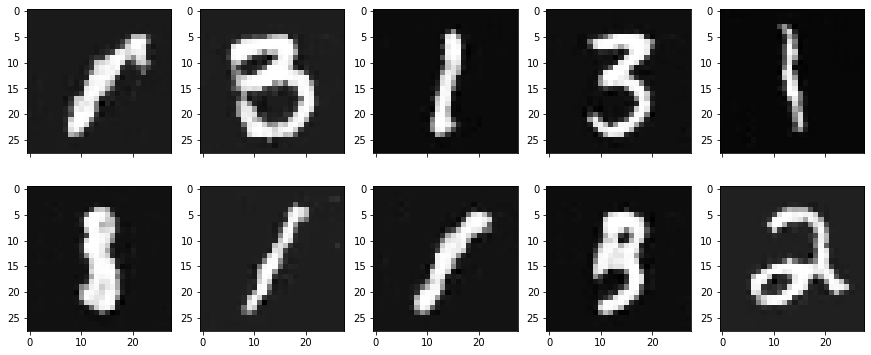

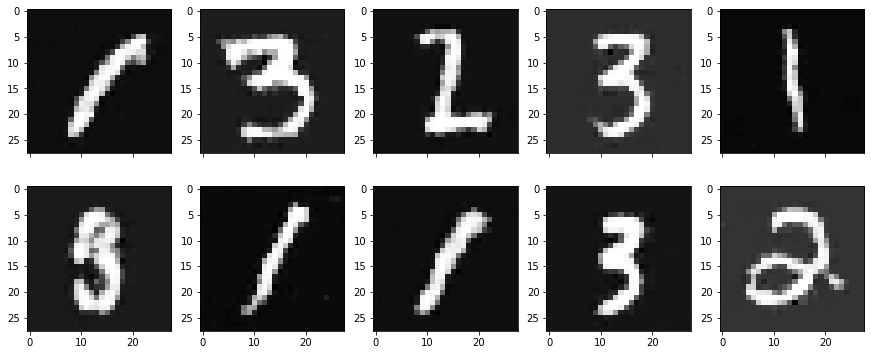

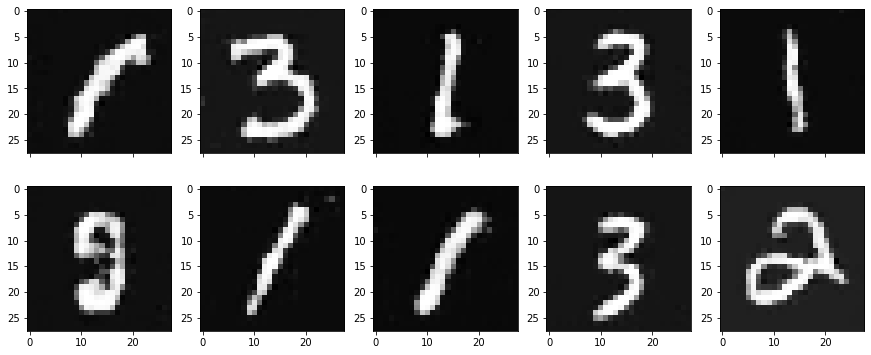

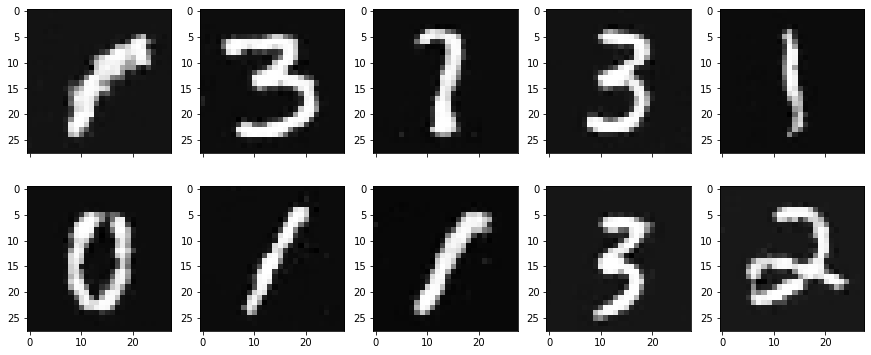

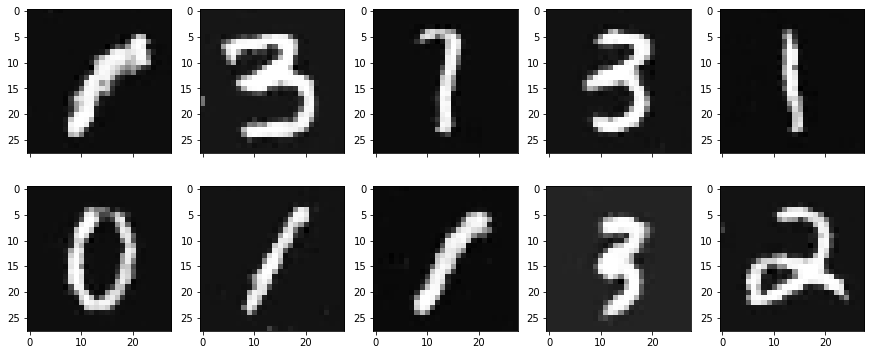

In [ ]:
%%time
train_dl = DataLoader(new_X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cur_X_test, batch_size=batch_size, shuffle=True)
prev_len = len(new_X_train)
lg, ld, rs, fs = fit_GAN(model, criterion, 50, lr=lr)


sum of 0 in generated samples: tensor(6302, device='cuda:0')
sum of 1 in generated samples: tensor(7087, device='cuda:0')
sum of 2 in generated samples: tensor(5696, device='cuda:0')
sum of 3 in generated samples: tensor(5669, device='cuda:0')


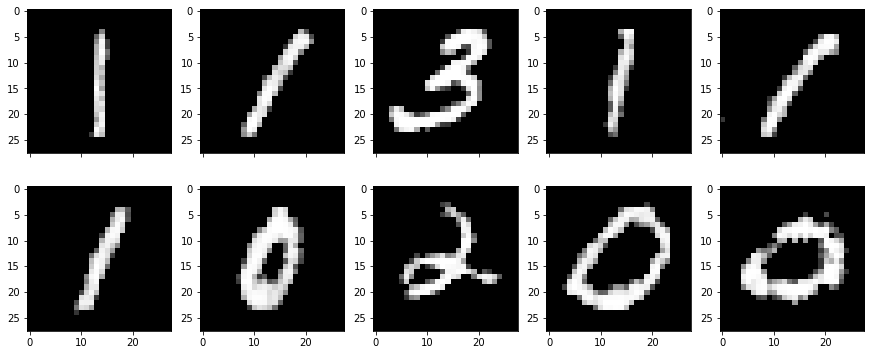

In [ ]:
generator.eval()
discriminator.eval()
lenet.eval()
train_latent = torch.randn(len(new_X_train), latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model['generator'](train_latent)
fake_images[fake_images <= 2e-1] = 0
fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(fake_images[j].detach().squeeze().cpu(), cmap ='gray')
for j in range(5):
    ax[1][j].imshow(fake_images[j+5].detach().squeeze().cpu(),cmap='gray')

prev_X = torch.clone(fake_images)
with torch.no_grad():
    prev_y = lenet(prev_X).argmax(axis=1)

for i in range(max(prev_y)+1):
    print(f'sum of {i} in generated samples:', sum(prev_y == i))


torch.cuda.empty_cache()

In [ ]:
new_X_train = torch.cat((prev_X, X_train_45.to(device)))
new_y_train = torch.cat((prev_y, y_train_45.to(device)))
permutation = np.random.permutation(len(new_X_train))
new_X_train = new_X_train[permutation]
new_y_train = new_y_train[permutation]
prev_X_test = torch.cat((prev_X_test, X_test_23))
prev_y_test = torch.cat((prev_y_test, y_test_23.to(device)))
cur_X_test = torch.cat((prev_X_test, X_test_45))
cur_y_test = torch.cat((prev_y_test, y_test_45.to(device)))
my_ewc = EWC(prev_X, prev_y)


In [ ]:
%%time
test_acc, test_loss = ewc_train(new_X_train, new_y_train, cur_X_test, cur_y_test, prev_X_test, 
          prev_y_test, number=3, ewc=my_ewc, importance=3.3e10, epochs=10) #обучаем классификатор на 012345

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
accuracy on current task:  tensor(0.9013)
accuracy on old task:  tensor(0.9213)
accuracy on 01:  tensor(0.9229)
accuracy on 23:  tensor(0.8668)
accuracy on 45:  tensor(0.8639)
accuracy on current task:  tensor(0.9098)
accuracy on old task:  tensor(0.9062)
accuracy on 01:  tensor(0.9050)
accuracy on 23:  tensor(0.8776)
accuracy on 45:  tensor(0.9055)
accuracy on current task:  tensor(0.9151)
accuracy on old task:  tensor(0.9225)
accuracy on 01:  tensor(0.9040)
accuracy on 23:  tensor(0.8643)
accuracy on 45:  tensor(0.9242)
accuracy on current task:  tensor(0.9197)
accuracy on old task:  tensor(0.9257)
accuracy on 01:  tensor(0.9002)
accuracy on 23:  tensor(0.8815)
accuracy on 45:  tensor(0.9194)
accuracy on current task:  tensor(0.9206)
accuracy on old task:  tensor(0.9144)
accuracy on 01:  tensor(0.9078)
accuracy on 23:  tensor(0.8805)
accuracy on 45:  tensor(0.9285)
accuracy on current task:  tensor(0.9314)
accuracy on ol

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 0.5933, loss_d: 1.0129, real_score: 0.7466, fake_score: 0.2528


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 0.6320, loss_d: 0.9728, real_score: 0.7716, fake_score: 0.2300


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 0.6064, loss_d: 0.9730, real_score: 0.7599, fake_score: 0.2407


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 0.6132, loss_d: 0.9768, real_score: 0.7590, fake_score: 0.2402


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 0.6105, loss_d: 0.9681, real_score: 0.7633, fake_score: 0.2375


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 0.5926, loss_d: 0.9790, real_score: 0.7538, fake_score: 0.2441


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 0.5935, loss_d: 0.9902, real_score: 0.7479, fake_score: 0.2520


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 0.5835, loss_d: 0.9884, real_score: 0.7480, fake_score: 0.2537


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 0.5851, loss_d: 0.9920, real_score: 0.7446, fake_score: 0.2560


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 0.5914, loss_d: 0.9825, real_score: 0.7470, fake_score: 0.2506


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 0.5847, loss_d: 0.9975, real_score: 0.7428, fake_score: 0.2582


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 0.5718, loss_d: 1.0025, real_score: 0.7378, fake_score: 0.2624


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 0.5809, loss_d: 1.0023, real_score: 0.7369, fake_score: 0.2636


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 0.5761, loss_d: 1.0023, real_score: 0.7338, fake_score: 0.2653


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 0.5704, loss_d: 1.0096, real_score: 0.7310, fake_score: 0.2681


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 0.5786, loss_d: 0.9975, real_score: 0.7364, fake_score: 0.2640


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 0.5685, loss_d: 1.0124, real_score: 0.7296, fake_score: 0.2705


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 0.5720, loss_d: 1.0040, real_score: 0.7340, fake_score: 0.2666


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 0.5647, loss_d: 1.0135, real_score: 0.7299, fake_score: 0.2704


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 0.5662, loss_d: 1.0161, real_score: 0.7272, fake_score: 0.2729


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 0.5702, loss_d: 1.0109, real_score: 0.7301, fake_score: 0.2696


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 0.5633, loss_d: 1.0185, real_score: 0.7259, fake_score: 0.2726


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 0.5636, loss_d: 1.0106, real_score: 0.7290, fake_score: 0.2705


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 0.5704, loss_d: 1.0106, real_score: 0.7293, fake_score: 0.2701


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 0.5603, loss_d: 1.0091, real_score: 0.7318, fake_score: 0.2686


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 0.5575, loss_d: 1.0144, real_score: 0.7294, fake_score: 0.2707


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 0.5680, loss_d: 1.0241, real_score: 0.7263, fake_score: 0.2744


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 0.5723, loss_d: 1.0088, real_score: 0.7324, fake_score: 0.2679


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 0.5647, loss_d: 1.0171, real_score: 0.7286, fake_score: 0.2726


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 0.5653, loss_d: 1.0053, real_score: 0.7311, fake_score: 0.2679


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 0.5698, loss_d: 1.0144, real_score: 0.7304, fake_score: 0.2697


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 0.5732, loss_d: 1.0079, real_score: 0.7324, fake_score: 0.2677


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 0.5654, loss_d: 1.0104, real_score: 0.7317, fake_score: 0.2674


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 0.5580, loss_d: 1.0219, real_score: 0.7281, fake_score: 0.2721


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 0.5594, loss_d: 1.0151, real_score: 0.7301, fake_score: 0.2683


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 0.5653, loss_d: 1.0113, real_score: 0.7315, fake_score: 0.2688


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 0.5672, loss_d: 1.0084, real_score: 0.7320, fake_score: 0.2680


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 0.5677, loss_d: 1.0193, real_score: 0.7301, fake_score: 0.2697


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 0.5736, loss_d: 1.0072, real_score: 0.7335, fake_score: 0.2662


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 0.5783, loss_d: 1.0057, real_score: 0.7352, fake_score: 0.2638


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 0.5731, loss_d: 1.0153, real_score: 0.7306, fake_score: 0.2683


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 0.5781, loss_d: 1.0029, real_score: 0.7378, fake_score: 0.2628


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 0.5724, loss_d: 1.0123, real_score: 0.7345, fake_score: 0.2651


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 0.5782, loss_d: 0.9999, real_score: 0.7394, fake_score: 0.2611


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 0.5748, loss_d: 1.0048, real_score: 0.7386, fake_score: 0.2613


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 0.5795, loss_d: 1.0058, real_score: 0.7363, fake_score: 0.2641


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 0.5761, loss_d: 1.0014, real_score: 0.7403, fake_score: 0.2598


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 0.5857, loss_d: 1.0046, real_score: 0.7388, fake_score: 0.2609


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 0.5776, loss_d: 1.0017, real_score: 0.7407, fake_score: 0.2596


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 0.5855, loss_d: 1.0075, real_score: 0.7401, fake_score: 0.2606


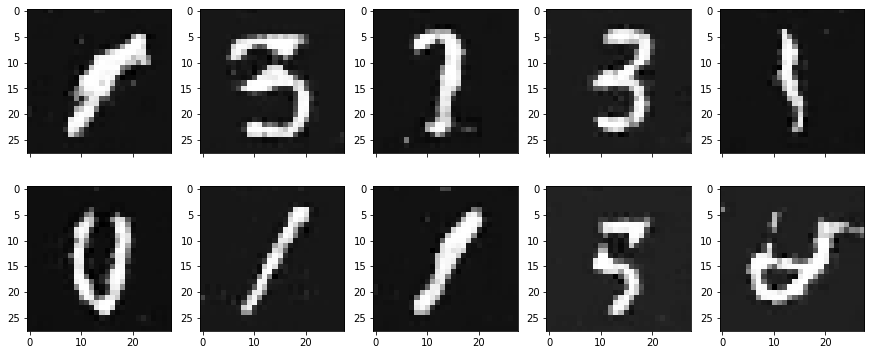

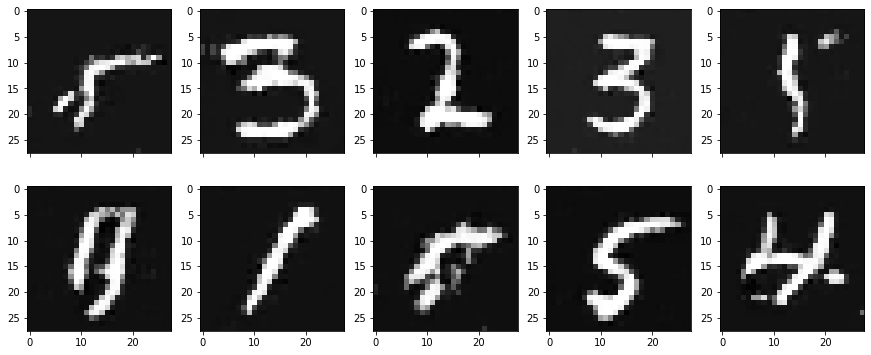

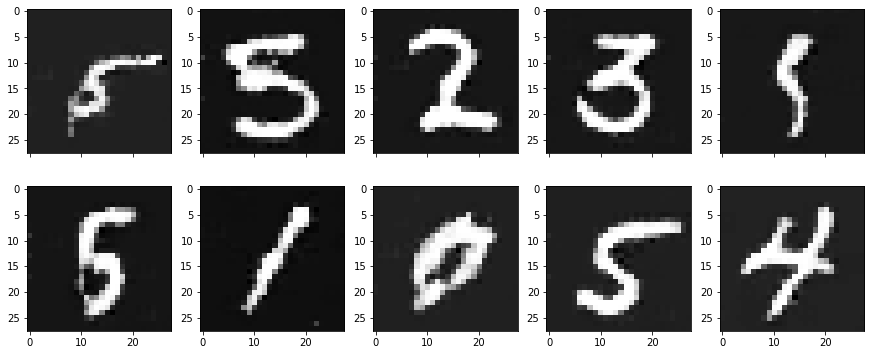

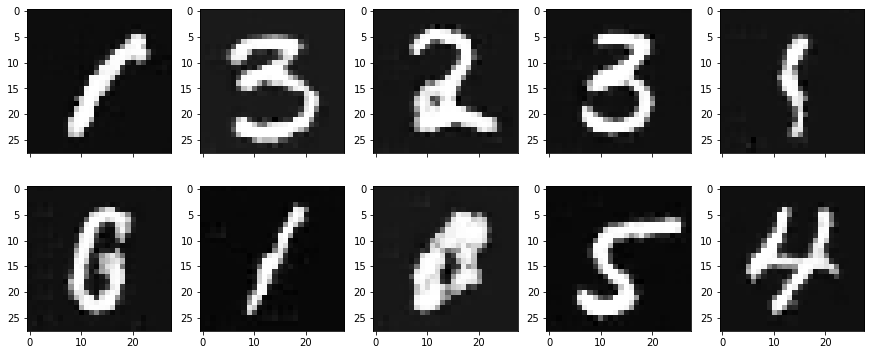

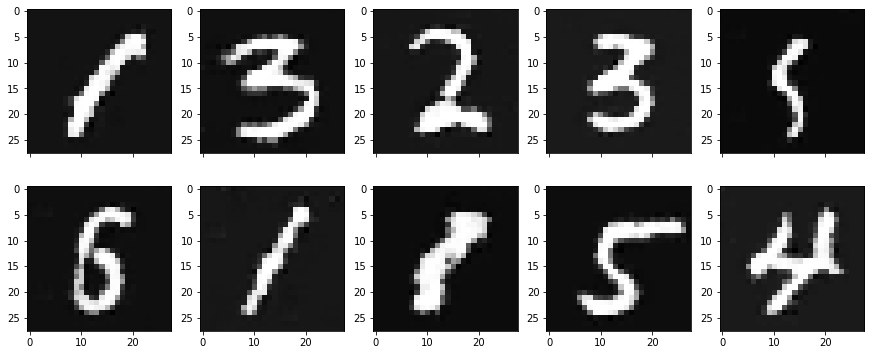

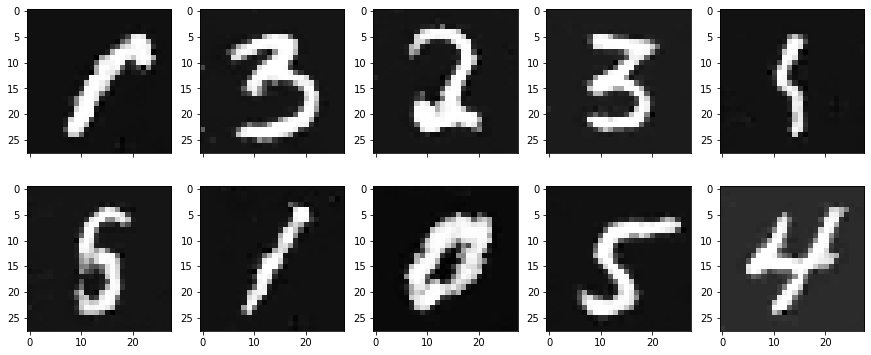

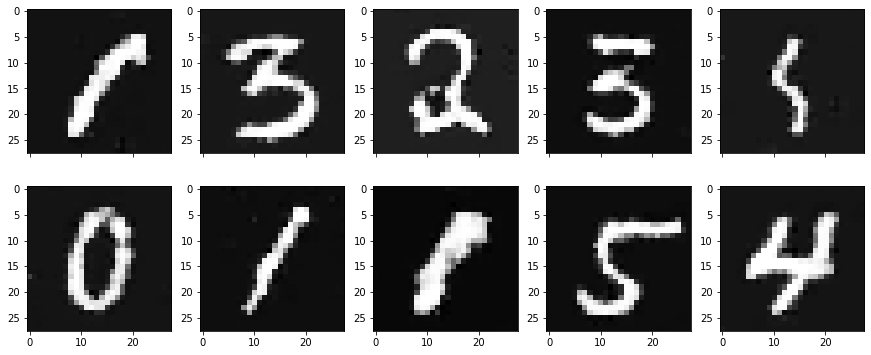

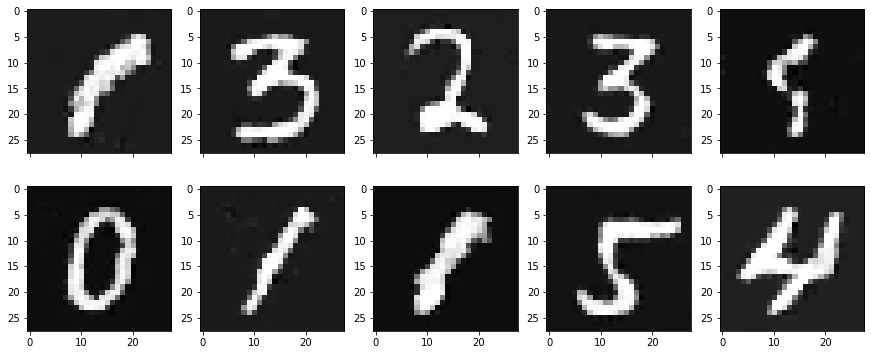

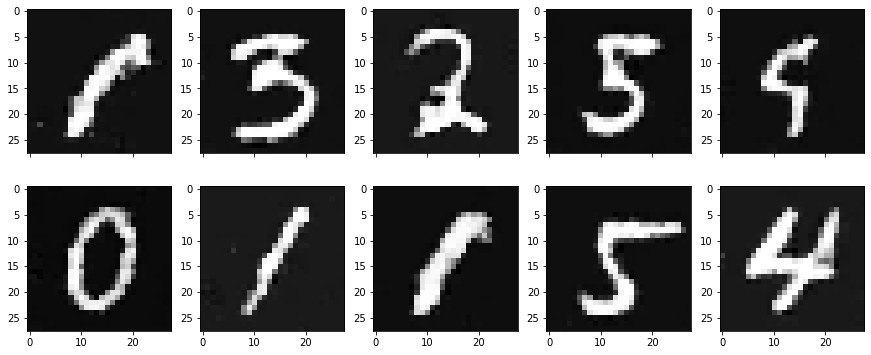

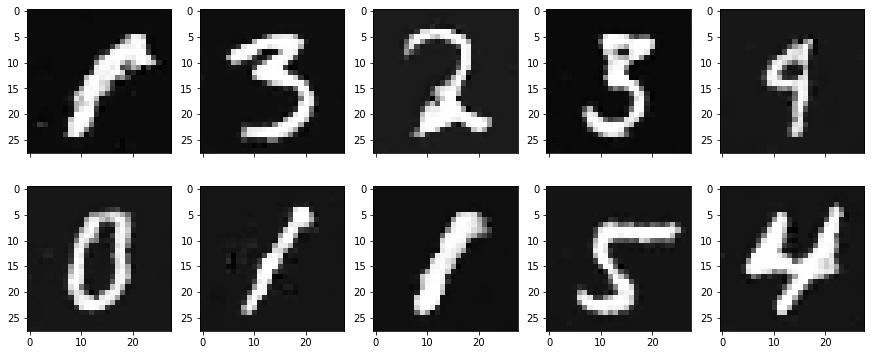

In [ ]:
%%time
train_dl = DataLoader(new_X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cur_X_test, batch_size=batch_size, shuffle=True)
prev_len = len(new_X_train)

lg, ld, rs, fs = fit_GAN(model, criterion, 50, lr=lr)


sum of 0 in generated samples: tensor(6491, device='cuda:0')
sum of 1 in generated samples: tensor(7264, device='cuda:0')
sum of 2 in generated samples: tensor(5525, device='cuda:0')
sum of 3 in generated samples: tensor(5629, device='cuda:0')
sum of 4 in generated samples: tensor(6021, device='cuda:0')
sum of 5 in generated samples: tensor(5087, device='cuda:0')


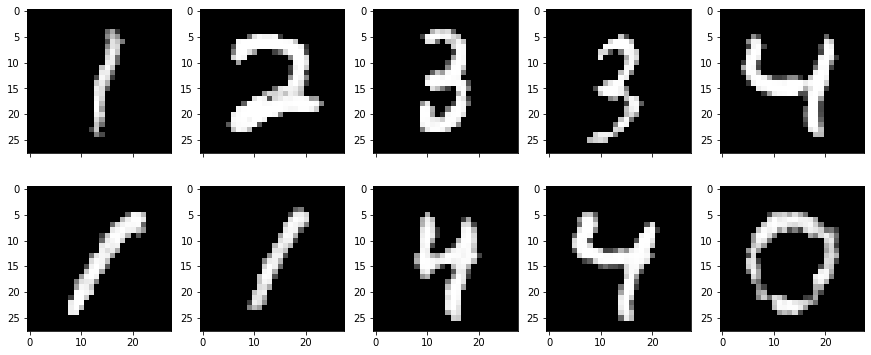

In [ ]:
generator.eval()
discriminator.eval()
lenet.eval()
train_latent = torch.randn(len(new_X_train), latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model['generator'](train_latent)
fake_images[fake_images <= 2e-1] = 0
fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(fake_images[j].detach().squeeze().cpu(), cmap ='gray')
for j in range(5):
    ax[1][j].imshow(fake_images[j+5].detach().squeeze().cpu(),cmap='gray')

prev_X = torch.clone(fake_images)
with torch.no_grad():
    prev_y = lenet(prev_X).argmax(axis=1)

for i in range(max(prev_y)+1):
    print(f'sum of {i} in generated samples:', sum(prev_y == i))


torch.cuda.empty_cache()

In [ ]:
new_X_train = torch.cat((prev_X, X_train_67.to(device)))
new_y_train = torch.cat((prev_y, y_train_67.to(device)))
permutation = np.random.permutation(len(new_X_train))
new_X_train = new_X_train[permutation]
new_y_train = new_y_train[permutation]
prev_X_test = torch.cat((prev_X_test, X_test_45))
prev_y_test = torch.cat((prev_y_test, y_test_45.to(device)))
cur_X_test = torch.cat((prev_X_test, X_test_67))
cur_y_test = torch.cat((prev_y_test, y_test_67.to(device)))
my_ewc = EWC(prev_X, prev_y)


In [ ]:
%%time
test_acc, test_loss = ewc_train(new_X_train, new_y_train, cur_X_test, cur_y_test, prev_X_test, 
          prev_y_test, number=4, ewc=my_ewc, importance=3.3e10, epochs=10) #обучаем классификатор на 01234567

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
accuracy on current task:  tensor(0.9103)
accuracy on old task:  tensor(0.9093)
accuracy on 01:  tensor(0.9121)
accuracy on 23:  tensor(0.8668)
accuracy on 45:  tensor(0.8965)
accuracy on 67:  tensor(0.8922)
accuracy on current task:  tensor(0.9230)
accuracy on old task:  tensor(0.9216)
accuracy on 01:  tensor(0.9225)
accuracy on 23:  tensor(0.8790)
accuracy on 45:  tensor(0.9013)
accuracy on 67:  tensor(0.8993)
accuracy on current task:  tensor(0.9234)
accuracy on old task:  tensor(0.9151)
accuracy on 01:  tensor(0.9139)
accuracy on 23:  tensor(0.8624)
accuracy on 45:  tensor(0.9018)
accuracy on 67:  tensor(0.9366)
accuracy on current task:  tensor(0.9243)
accuracy on old task:  tensor(0.9280)
accuracy on 01:  tensor(0.9144)
accuracy on 23:  tensor(0.8800)
accuracy on 45:  tensor(0.9114)
accuracy on 67:  tensor(0.9139)
accuracy on current task:  tensor(0.9277)
accuracy on old task:  tensor(0.9197)
accuracy on 01:  tensor(

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 0.6117, loss_d: 1.0098, real_score: 0.7599, fake_score: 0.2407


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 0.6020, loss_d: 1.0023, real_score: 0.7540, fake_score: 0.2467


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 0.5720, loss_d: 1.0155, real_score: 0.7357, fake_score: 0.2639


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 0.5553, loss_d: 1.0382, real_score: 0.7205, fake_score: 0.2796


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 0.5525, loss_d: 1.0517, real_score: 0.7132, fake_score: 0.2868


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 0.5442, loss_d: 1.0510, real_score: 0.7107, fake_score: 0.2897


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 0.5341, loss_d: 1.0549, real_score: 0.7080, fake_score: 0.2916


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 0.5375, loss_d: 1.0406, real_score: 0.7136, fake_score: 0.2867


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 0.5364, loss_d: 1.0557, real_score: 0.7078, fake_score: 0.2927


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 0.5355, loss_d: 1.0540, real_score: 0.7061, fake_score: 0.2943


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 0.5403, loss_d: 1.0540, real_score: 0.7063, fake_score: 0.2936


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 0.5422, loss_d: 1.0446, real_score: 0.7103, fake_score: 0.2892


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 0.5349, loss_d: 1.0573, real_score: 0.7054, fake_score: 0.2946


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 0.5318, loss_d: 1.0535, real_score: 0.7073, fake_score: 0.2928


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 0.5379, loss_d: 1.0489, real_score: 0.7091, fake_score: 0.2924


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 0.5462, loss_d: 1.0385, real_score: 0.7147, fake_score: 0.2860


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 0.5429, loss_d: 1.0422, real_score: 0.7117, fake_score: 0.2874


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 0.5468, loss_d: 1.0435, real_score: 0.7131, fake_score: 0.2853


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 0.5438, loss_d: 1.0373, real_score: 0.7175, fake_score: 0.2823


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 0.5438, loss_d: 1.0405, real_score: 0.7137, fake_score: 0.2863


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 0.5578, loss_d: 1.0425, real_score: 0.7142, fake_score: 0.2849


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 0.5515, loss_d: 1.0380, real_score: 0.7149, fake_score: 0.2848


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 0.5525, loss_d: 1.0371, real_score: 0.7188, fake_score: 0.2815


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 0.5510, loss_d: 1.0288, real_score: 0.7198, fake_score: 0.2795


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 0.5535, loss_d: 1.0387, real_score: 0.7184, fake_score: 0.2821


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 0.5590, loss_d: 1.0301, real_score: 0.7229, fake_score: 0.2777


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 0.5557, loss_d: 1.0329, real_score: 0.7207, fake_score: 0.2798


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 0.5496, loss_d: 1.0236, real_score: 0.7258, fake_score: 0.2744


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 0.5615, loss_d: 1.0489, real_score: 0.7195, fake_score: 0.2802


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 0.5550, loss_d: 1.0332, real_score: 0.7194, fake_score: 0.2812


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 0.5525, loss_d: 1.0263, real_score: 0.7220, fake_score: 0.2769


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 0.5546, loss_d: 1.0342, real_score: 0.7213, fake_score: 0.2797


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 0.5506, loss_d: 1.0180, real_score: 0.7271, fake_score: 0.2728


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 0.5620, loss_d: 1.0304, real_score: 0.7267, fake_score: 0.2728


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 0.5502, loss_d: 1.0319, real_score: 0.7224, fake_score: 0.2781


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 0.5499, loss_d: 1.0267, real_score: 0.7242, fake_score: 0.2759


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 0.5569, loss_d: 1.0312, real_score: 0.7218, fake_score: 0.2776


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 0.5526, loss_d: 1.0289, real_score: 0.7214, fake_score: 0.2796


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 0.5517, loss_d: 1.0359, real_score: 0.7217, fake_score: 0.2788


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 0.5614, loss_d: 1.0209, real_score: 0.7272, fake_score: 0.2717


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 0.5647, loss_d: 1.0119, real_score: 0.7337, fake_score: 0.2669


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 0.5571, loss_d: 1.0288, real_score: 0.7257, fake_score: 0.2742


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 0.5453, loss_d: 1.0252, real_score: 0.7272, fake_score: 0.2732


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 0.5553, loss_d: 1.0227, real_score: 0.7253, fake_score: 0.2726


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 0.5563, loss_d: 1.0255, real_score: 0.7257, fake_score: 0.2743


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 0.5601, loss_d: 1.0182, real_score: 0.7307, fake_score: 0.2687


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 0.5647, loss_d: 1.0212, real_score: 0.7271, fake_score: 0.2741


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 0.5639, loss_d: 1.0174, real_score: 0.7316, fake_score: 0.2677


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 0.5677, loss_d: 1.0230, real_score: 0.7300, fake_score: 0.2720


  0%|          | 0/377 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 0.5624, loss_d: 1.0234, real_score: 0.7267, fake_score: 0.2720


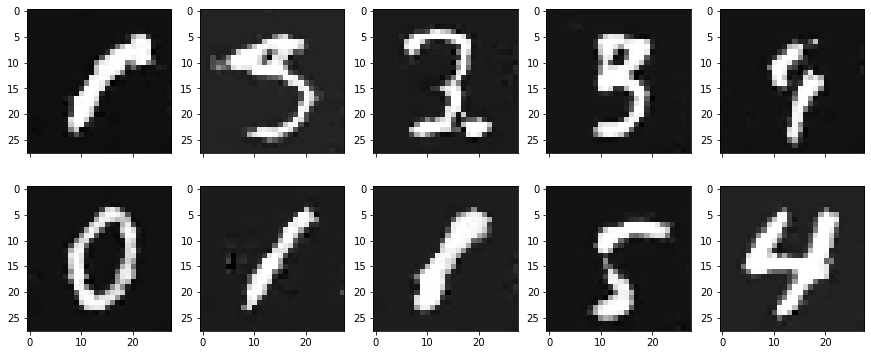

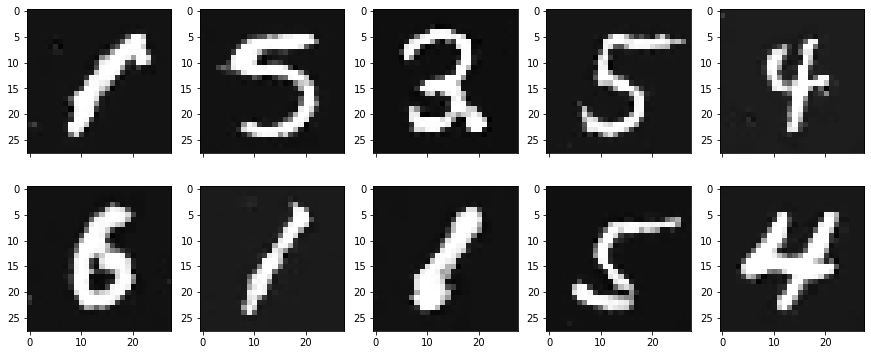

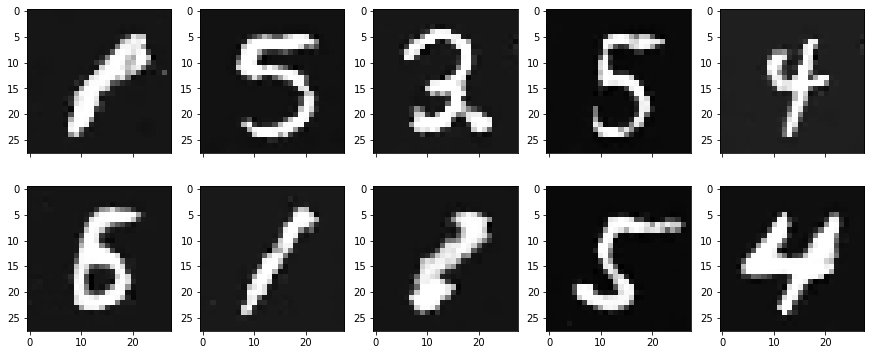

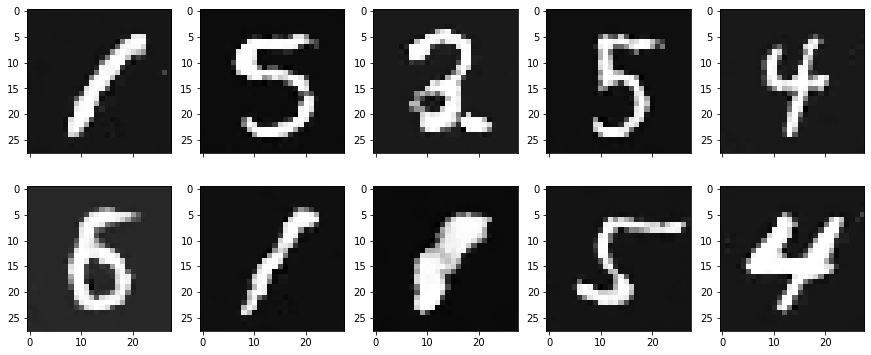

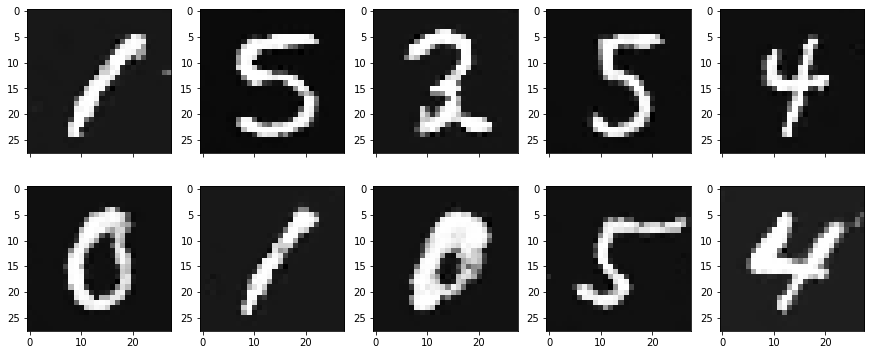

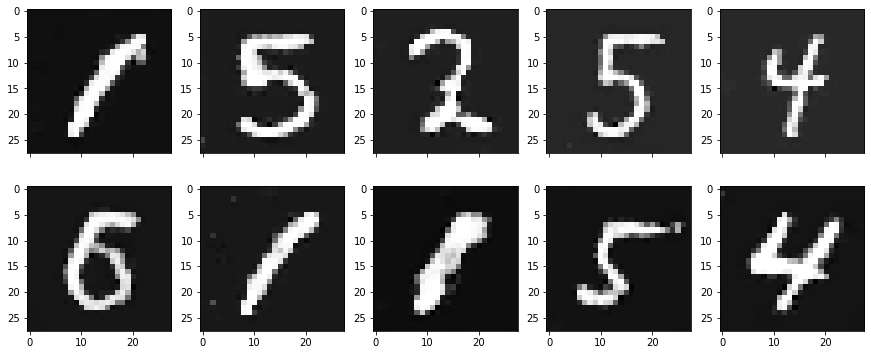

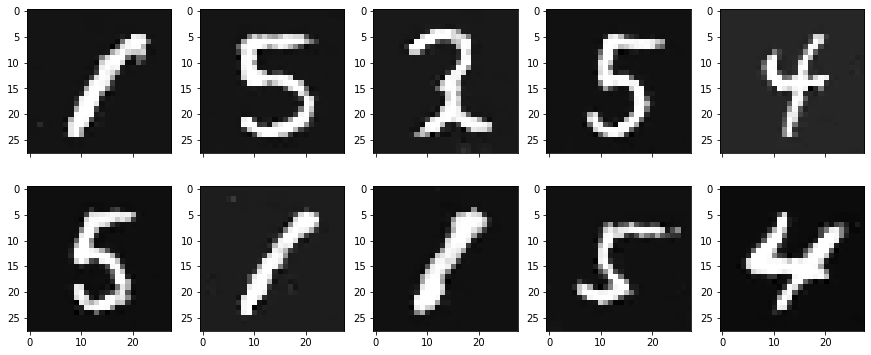

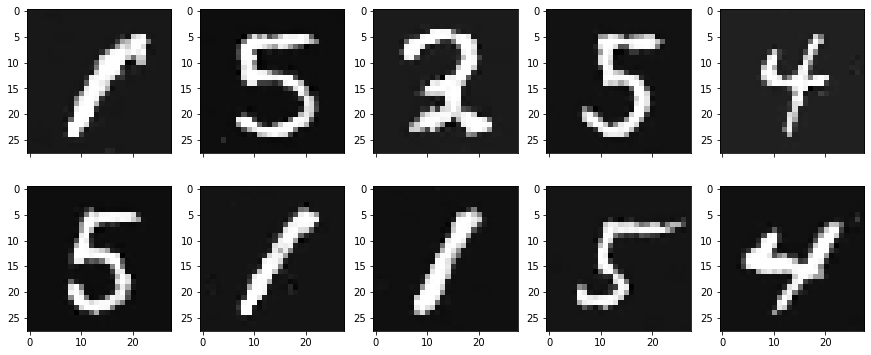

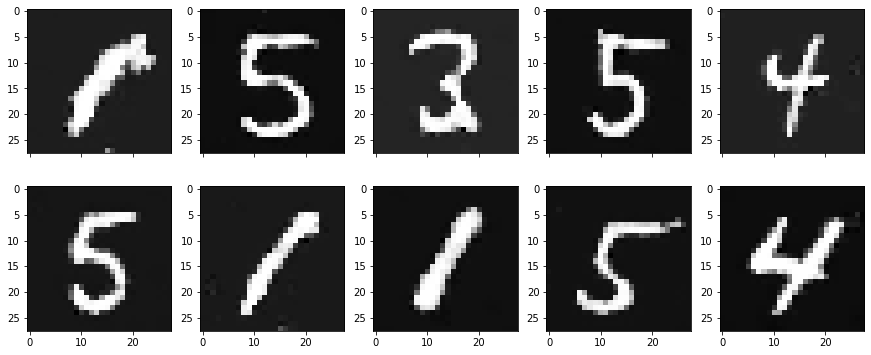

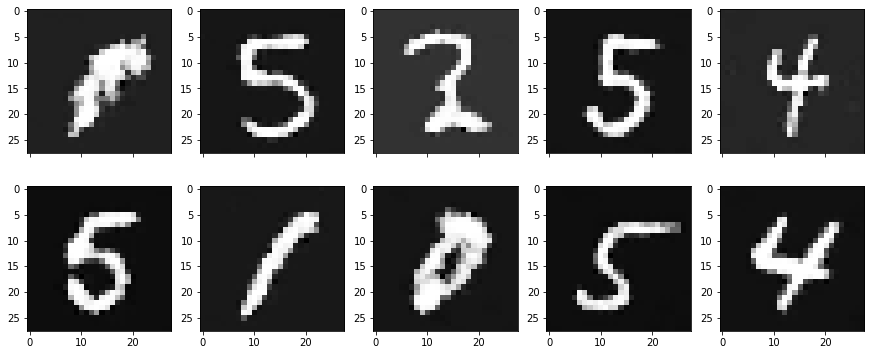

In [ ]:

train_dl = DataLoader(new_X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cur_X_test, batch_size=batch_size, shuffle=True)
prev_len = len(new_X_train)
%time
lg, ld, rs, fs = fit_GAN(model, criterion, 50, lr=lr)

torch.cuda.empty_cache()

sum of 0 in generated samples: tensor(6320, device='cuda:0')
sum of 1 in generated samples: tensor(8062, device='cuda:0')
sum of 2 in generated samples: tensor(5153, device='cuda:0')
sum of 3 in generated samples: tensor(6227, device='cuda:0')
sum of 4 in generated samples: tensor(5575, device='cuda:0')
sum of 5 in generated samples: tensor(4835, device='cuda:0')
sum of 6 in generated samples: tensor(6116, device='cuda:0')
sum of 7 in generated samples: tensor(5912, device='cuda:0')


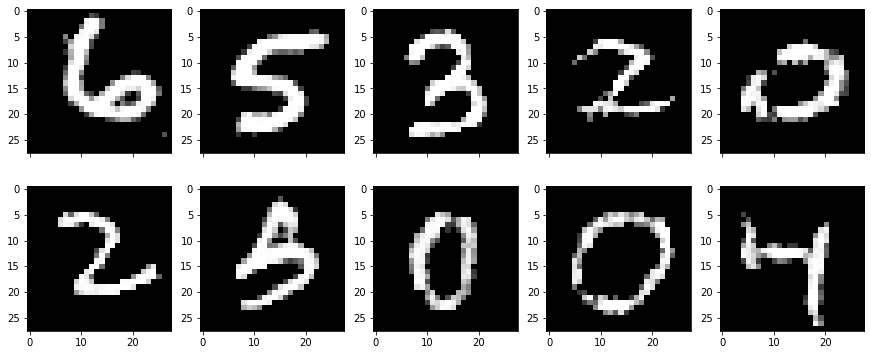

In [ ]:
generator.eval()
discriminator.eval()
lenet.eval()
train_latent = torch.randn(len(new_X_train), latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model['generator'](train_latent)
fake_images[fake_images <= 2e-1] = 0
fig, ax = plt.subplots(2,5, figsize = (15, 6), sharex = True)
for j in range(5):
    ax[0][j].imshow(fake_images[j].detach().squeeze().cpu(), cmap ='gray')
for j in range(5):
    ax[1][j].imshow(fake_images[j+5].detach().squeeze().cpu(),cmap='gray')

prev_X = torch.clone(fake_images)
with torch.no_grad():
    prev_y = lenet(prev_X).argmax(axis=1)

for i in range(max(prev_y)+1):
    print(f'sum of {i} in generated samples:', sum(prev_y == i))

torch.cuda.empty_cache()

In [ ]:
new_X_train = torch.cat((prev_X, X_train_89.to(device)))
new_y_train = torch.cat((prev_y, y_train_89.to(device)))
permutation = np.random.permutation(len(new_X_train))
new_X_train = new_X_train[permutation]
new_y_train = new_y_train[permutation]
prev_X_test = torch.cat((prev_X_test, X_test_67))
prev_y_test = torch.cat((prev_y_test, y_test_67.to(device)))
cur_X_test = torch.cat((prev_X_test, X_test_89))
cur_y_test = torch.cat((prev_y_test, y_test_89.to(device)))
my_ewc = EWC(prev_X, prev_y)

In [ ]:
%%time
test_acc, test_loss = ewc_train(new_X_train, new_y_train, cur_X_test, cur_y_test, prev_X_test, 
          prev_y_test, number=5, ewc=my_ewc, importance=2.7e10, epochs=10) #обучаем классификатор на 0123456789

accuracy on current task:  tensor(0.8844)
accuracy on old task:  tensor(0.8842)
accuracy on 01:  tensor(0.8757)
accuracy on 23:  tensor(0.8477)
accuracy on 45:  tensor(0.8228)
accuracy on 67:  tensor(0.8922)
accuracy on 89:  tensor(0.8558)
accuracy on current task:  tensor(0.8989)
accuracy on old task:  tensor(0.9092)
accuracy on 01:  tensor(0.9031)
accuracy on 23:  tensor(0.8722)
accuracy on 45:  tensor(0.8650)
accuracy on 67:  tensor(0.9089)
accuracy on 89:  tensor(0.8250)
accuracy on current task:  tensor(0.9009)
accuracy on old task:  tensor(0.9091)
accuracy on 01:  tensor(0.9182)
accuracy on 23:  tensor(0.8389)
accuracy on 45:  tensor(0.8735)
accuracy on 67:  tensor(0.9048)
accuracy on 89:  tensor(0.8487)
accuracy on current task:  tensor(0.9034)
accuracy on old task:  tensor(0.9084)
accuracy on 01:  tensor(0.9182)
accuracy on 23:  tensor(0.8433)
accuracy on 45:  tensor(0.8842)
accuracy on 67:  tensor(0.9038)
accuracy on 89:  tensor(0.8558)
accuracy on current task:  tensor(0.9011